In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.models.particle_filter import ParticleFilterMLP

In [2]:
data_name = "DS03"
perform_name = "T48"
device = "cpu"  # or "cuda"

experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'

In [3]:
net = ParticleFilterMLP(state_dim=5,hidden_dims=[128, 128, 32])

net.load_state_dict(
    torch.load(
        states_dir / perform_name / "best_pf_net.pt",
        map_location=device,
    )
)

net = net.to(device)
net.eval()    # or net.train()

ParticleFilterMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)

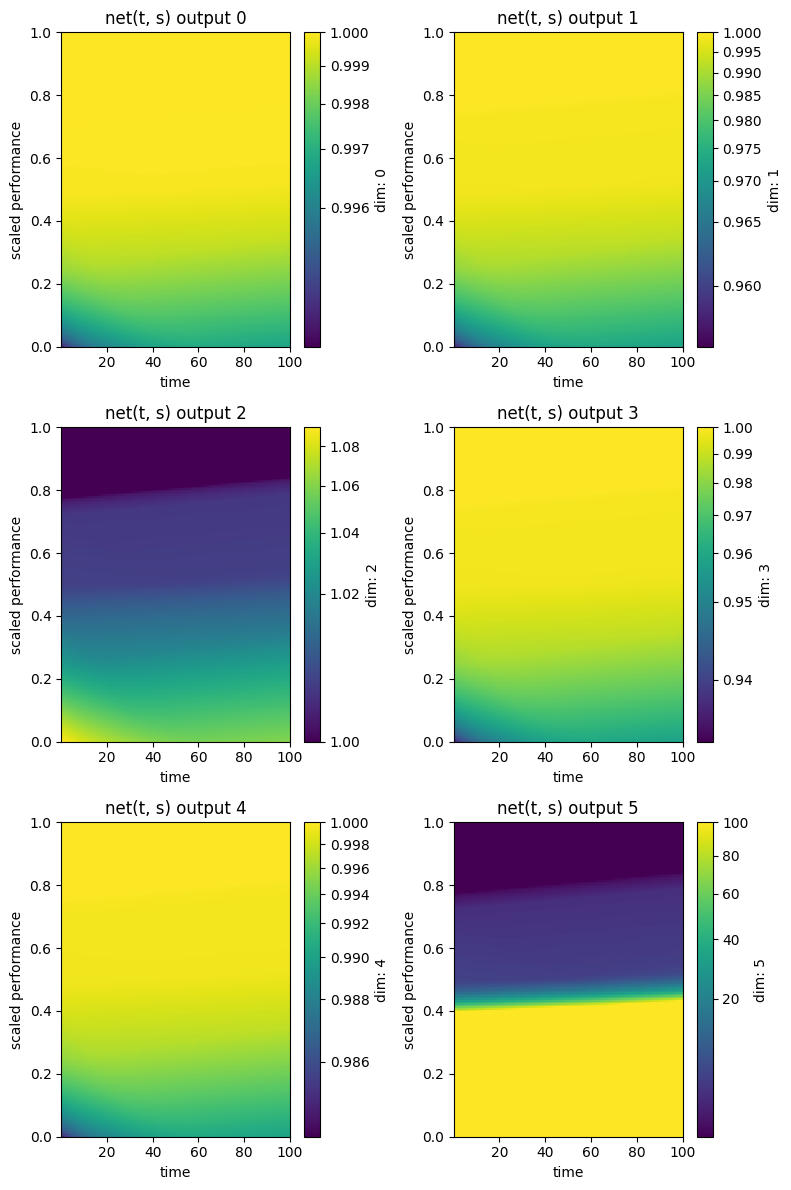

In [4]:
t_grid = np.linspace(0.1, 100, 300)
s_grid = np.linspace(0.0, 1.0, 200)

net.eval()

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
vmax = 5*[None]+ [100]
for i in range(6):
	net.plot_output(
		t=t_grid,
		s=s_grid,
		dim=i,
  		vmax=vmax[i],
		ax=axes[i//2, i%2],
		title=f"net(t, s) output {i}",
	)


plt.tight_layout()
plt.show()